# Coursework for Artificial Intelligence M COMPSCI5087 2024-2025

## Imports

In [ ]:
import os, sys
import networkx as nx
import json
import numpy as np
from scipy.stats import pearsonr

from matplotlib import use
import matplotlib.pyplot as plt
import ipywidgets as widgets
use("Agg")

import warnings
warnings.filterwarnings("ignore")

import maze as m
import solvers as solv

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

%load_ext autoreload
%autoreload 2

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


## Parameters

In [2]:
# N = [11] # Growing number of tiles on the side
N = [11, 15, 21, 25, 31] # Growing number of tiles on the side
M = 2 # Fixed number of wormholes

n_repetitions = 20
folder = "N01"

## Setup

In [3]:
results_dir = "solved"
series_dir = os.path.join(results_dir, folder)
if not os.path.isdir(results_dir): os.mkdir(results_dir)
if not os.path.isdir(series_dir): os.mkdir(series_dir)

filepath = lambda N, label, k, extension : os.path.join(series_dir, f"{label}_{N:02.0f}_{k:02.0f}.{extension}")

## Problem Description

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are one-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), but from (0,7) you can't go to (2,1).

Important properties
- Branching factor? $b=5$, due to the 5 possible actions; could be optimistically lowered to 3 for most cases, since most tiles are only connected to 2 neighbours.
- Depth of the solution? $d\leq 4(N-2)^2$ with no teleportation links, effectively less with teleportation links

## Solver description

The **heuristic function** $h$ is an arbitrary, non-negative, problem-specific function with one constrain: if $n$ is a goal node, then $h(n)=0$.

_The tree-search version of A-star is optimal if the heuristic function is **admissible**_. 

A heuristic function is admissible if it never overestimates the cost to reach a goal, i.e. an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is. _The most optimistic agent going down a wormhole will always assume that a wormhole can take you right to the exit._

_The graph-search version of A-star is optimal if the heuristic function is **consistent**_. 

A heuristic function is consistent if, for every node $n$ and every successor $n'$ of $n$ generated by any action $a$, the estimated cost of reaching the goal from $n$ is no greater than the step cost of getting to $n'$ plus the estimated cost of reaching the goal from $n'$:

$h(n) \leq c(n,a,n') + h(n')$

This is a form of the general triangle inequality. 

"For an admissible heuristic, the inequality makes perfect sense: if there were a route from $n$ to $G_n$ via $n'$ that was cheaper than $h(n)$, that would violate the property that $h()n)$is a lower bound on the cost to reach $G_n$" (Russel, S, & Norvig, P.: _Artificial Intelligence: A Modern Approach_, 3rd edition, Pearson Education, 2010, USA)

If $h$ is consistent, then the values of $f(n)$ along any path are nondecreasing.

My heuristic function $h(n_i)=h(n_i,n_{i-1},n_{i-2})$ is consistent, as it is defined by pieces according to three cases:

- For any tile $n_i$ that is neither the entrance nor the exit of a wormhole, $h(n_i)$ returns the Euclidean distance to the goal
- For any tile $n_i$ that is the entrance of a wormhole, $h(n_i)=h(n_{i-1})-c$ is returned so that $f(n_i)=f(n_{i-1})$ matches its parent's because $f(n_i)=h(n_i)+g(n_i)=h(n_i)+g(n_{i-1})+c$
- For any tile $n_i$ that is the exit of a wormhole, $h(n_i)=h(n_{i-2})-2c$ is returned so that $f(n_i)=f(n_{i-1})=f(n_{i-2})$ matches both its parent's and its grandparent's because $f(n_i)=f(n_{i-1})$ and $f(n_i)=h(n_i)+g(n_i)=h(n_i)+g(n_{i-1})+c=h(n_i)+g(n_{i-2})+2c$

## Experiment

In [ ]:
problem_branching_factors = []
problem_n_nodes = []

solution_n_steps = []
solution_depths = []
solution_n_frontier = []
solution_n_explored = []

In [5]:
for n in N:

    problem_branching_factors.append([])
    problem_n_nodes.append([])

    solution_n_steps.append([])
    solution_depths.append([])
    solution_n_frontier.append([])
    solution_n_explored.append([])

    for k in range(n_repetitions):

        print(f"> Maze size {n} > Repetition {k}")

        maze_problem = m.wormholes_maze_problem(n, M, show_plots=True)
        plt.savefig(filepath(n, "maze", k, "png"))
        plt.close()

        branching_factor = max([len(v) for (k,v) in maze_problem.graph.graph_dict.items()])
        problem_branching_factors[-1].append(branching_factor)
        problem_n_nodes[-1].append( len(maze_problem.graph.locations) )

        n_steps, solution_path, all_node_colors = solv.wormholes_maze_A_star_solver(maze_problem, verbose=False)

        print(f"Solved in {n_steps} iterations")

        solution_n_steps[-1].append(n_steps)
        solution_depths[-1].append(len(solution_path))

        with open(filepath(n, "path", k, "json"), 'w', encoding='utf-8') as f:
            json.dump(dict(solution_path=[node.state for node in solution_path]), f, 
                      ensure_ascii=False, indent=4)
            
        print("Saved solution path")

        n_frontier = sum([v=="orange" for v in all_node_colors[-1].values()])
        n_explored = sum([v in ["limegreen","gray"] for v in all_node_colors[-1].values()])
        solution_n_frontier[-1].append(n_frontier)
        solution_n_explored[-1].append(n_explored)
        
        print("Added all results to lists")

        m.show_wormholes_maze_problem(maze_problem, all_node_colors[-1], n_steps)
        fig = plt.savefig(filepath(n, "solution", k, "png"))
        plt.close(fig)

        print("Plotted")

> Maze size 11 > Repetition 0
Solved in 76 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 1
Solved in 46 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 2
Solved in 71 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 3
Solved in 87 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 4
Solved in 68 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 5
Solved in 106 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 6
Solved in 124 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 7
Solved in 60 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 8
Solved in 104 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 >

In [6]:
data = dict(problem_branching_factors=problem_branching_factors,
            problem_n_nodes=problem_n_nodes,
            solution_n_steps=solution_n_steps,
            solution_depths=solution_depths,
            solution_n_frontier=solution_n_frontier,
            solution_n_explored=solution_n_explored)

In [7]:
with open(os.path.join(series_dir, 'data.json'), 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

## Analysis

In [5]:
n_steps_mean = np.mean(solution_n_steps, axis=1)
n_steps_std = np.std(solution_n_steps, axis=1)

In [6]:
n_steps_mean

array([ 83.  , 156.3 , 279.3 , 428.15, 638.05])

In [7]:
n_steps_std / np.sqrt(n_repetitions)

array([ 5.79741322, 16.24547629, 30.67475346, 38.11589399, 49.54586133])

### Results Analysis

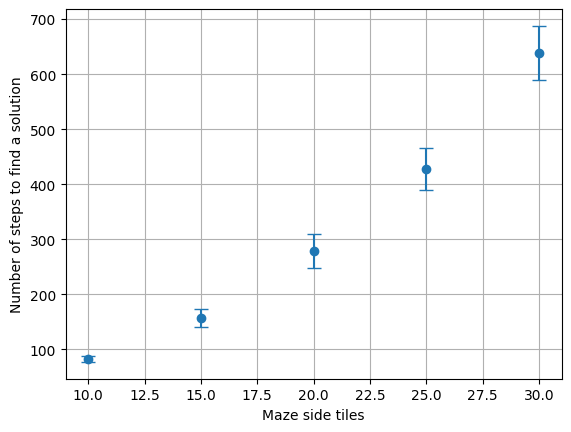

In [ ]:
plot_N = [10, 15, 20, 25, 30]

%matplotlib inline
plt.errorbar(plot_N, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.xlabel("Maze side tiles")
plt.ylabel("Number of steps to find a solution")
plt.grid()

plt.savefig(os.path.join(series_dir, "NPlot.png"))

In [8]:
depths_mean = np.mean(solution_depths, axis=1)
depths_std = np.std(solution_depths, axis=1)

In [9]:
depths_mean

array([15.65, 23.7 , 33.3 , 42.75, 55.25])

In [10]:
depths_std / np.sqrt(n_repetitions)

array([0.71510489, 1.51013244, 1.47326169, 1.3962002 , 2.00981964])

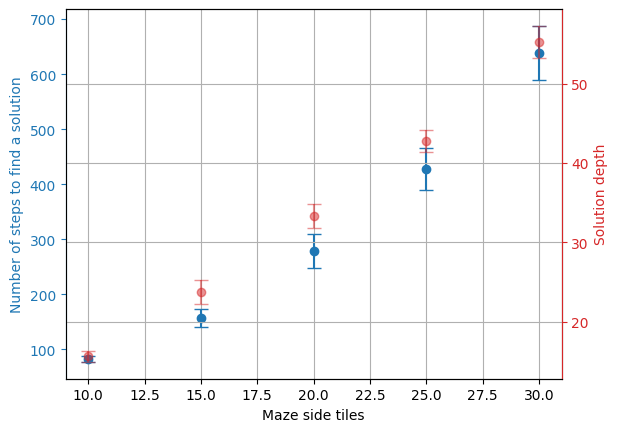

In [18]:
plot_N = [10, 15, 20, 25, 30]

%matplotlib inline
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)

ax.errorbar(plot_N, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="o", color="C0", linestyle="none", capsize=5)
ax2.errorbar(plot_N, depths_mean, depths_std / np.sqrt(n_repetitions), marker="o", color="C3", linestyle="none", alpha=0.5, capsize=5)
ax.set_xlabel("Maze side tiles")
ax.set_ylabel("Number of steps to find a solution")
ax2.set_ylabel("Solution depth")
ax.grid(axis="x")
ax2.grid()

ax.yaxis.label.set_color('C0')        #setting up X-axis label color to yellow
ax2.yaxis.label.set_color('C3')          #setting up Y-axis label color to blue

ax.tick_params(axis='y', colors='C0')    #setting up X-axis tick color to red
ax2.tick_params(axis='y', colors='C3')  #setting up Y-axis tick color to black

ax.spines['left'].set_color('C0')        # setting up Y-axis tick color to red
ax2.spines['right'].set_color('C3')         #setting up above X-axis tick color to red

# ax.plot([min(plot_N), max(plot_N)], [n_steps_mean.min(), n_steps_mean.max()], 
#          "C0", linewidth=1, linestyle="dashed")

plt.savefig(os.path.join(series_dir, "NPlot2.png"))

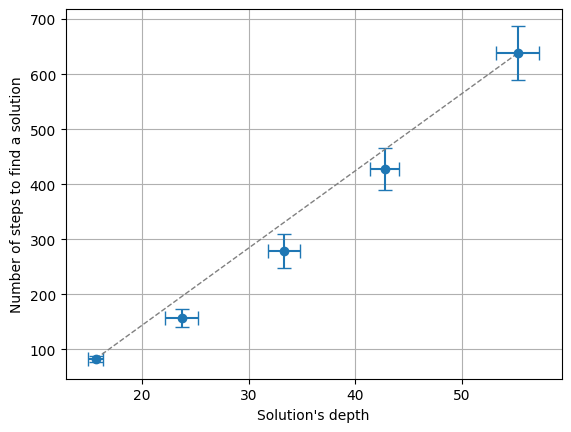

In [ ]:
%matplotlib inline
plt.errorbar(depths_mean, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), depths_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.plot([depths_mean.min(),depths_mean.max()], [n_steps_mean.min(), n_steps_mean.max()], 
         "gray", linewidth=1, linestyle="dashed")
plt.xlabel("Solution's depth")
plt.ylabel("Number of steps to find a solution")
plt.grid()

plt.savefig(os.path.join(series_dir, "NPlot3.png"))

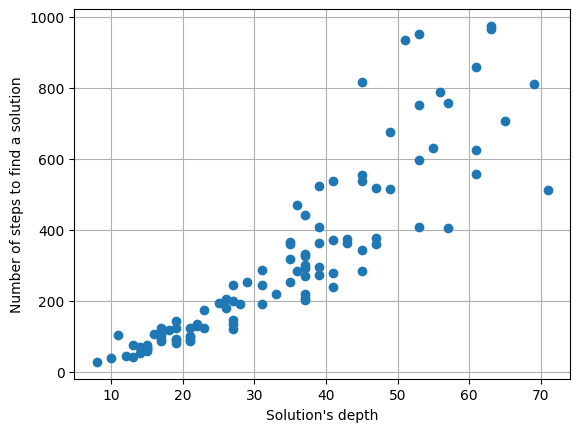

In [ ]:
%matplotlib inline
plt.plot(solution_depths.flatten(), solution_n_steps.flatten(), marker="o", linestyle="none")
plt.xlabel("Solution's depth")
plt.ylabel("Number of steps to find a solution")
plt.grid()

# plt.savefig(os.path.join(series_dir, "NPlot4.png"))

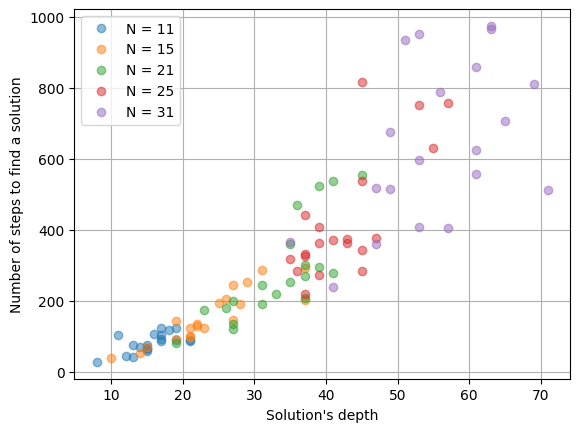

In [ ]:
%matplotlib inline
for k, n in enumerate(N):
    plt.plot(solution_depths[k], solution_n_steps[k], marker="o", linestyle="none", alpha=0.5, label=f"N = {n:.0f}")
plt.xlabel("Solution's depth")
plt.ylabel("Number of steps to find a solution")
plt.grid()
plt.legend()

plt.savefig(os.path.join(series_dir, "NPlot4.png"))
# plt.savefig(os.path.join(series_dir, "NPlot5.png"))

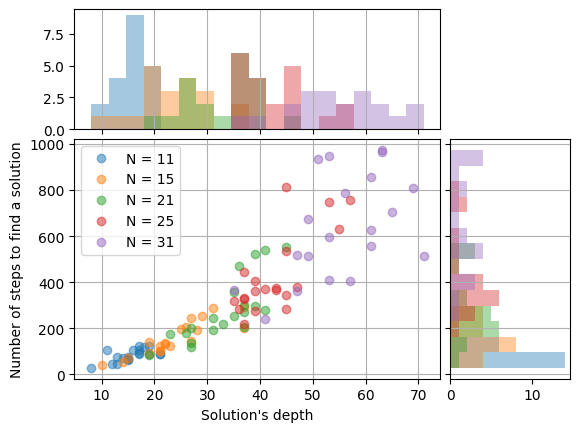

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()

for k, n in enumerate(N):
    ax.plot(solution_depths[k], solution_n_steps[k], marker="o", linestyle="none", alpha=0.5, label=f"N = {n:.0f}")
ax.legend()
ax.grid()

ax.set_xlabel("Solution's depth")
ax.set_ylabel("Number of steps to find a solution")

divider = make_axes_locatable(ax)
ax_hist_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_hist_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

ax_hist_x.xaxis.set_tick_params(labelbottom=False)
ax_hist_y.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 0.25
xymax = max(np.max(np.abs(solution_depths)), np.max(np.abs(solution_n_steps)))
lim = (int(xymax/binwidth) + 1)*binwidth


N_bins_x = 20
N_bins_y = 15
bins_x = np.linspace(solution_depths.min(), solution_depths.max(), N_bins_x)
bins_y = np.linspace(solution_n_steps.min(), solution_n_steps.max(), N_bins_y)

for k, n in enumerate(N):
    ax_hist_x.hist(solution_depths[k], bins=bins_x, alpha=0.4)
    ax_hist_y.hist(solution_n_steps[k], bins=bins_y, orientation='horizontal', alpha=0.4)
ax_hist_x.grid(axis="x")
ax_hist_y.grid(axis="y")

plt.savefig(os.path.join(series_dir, "NPlot6.png"))

In [ ]:
pearson_depths = pearsonr(N, depths_mean)
print(pearson_depths)

PearsonRResult(statistic=np.float64(0.9981680083465488), pvalue=np.float64(9.410218636833449e-05))


In [49]:
pearson_depths_all = pearsonr(np.array([[n]*n_repetitions for n in N]).flatten(), solution_depths.flatten())
print(pearson_depths_all)

PearsonRResult(statistic=np.float64(0.9016745009775795), pvalue=np.float64(1.8513599618134407e-37))


In [13]:
from scipy.optimize import curve_fit
from math import sqrt

def nonlinear_fit(X, Y, fitfunction, initial_guess=None, dY=None, 
                  parameters_bounds=(-np.inf, np.inf), **kwargs):

    """Applies nonlinear fit and returns parameters and Rsq. Plots it.
    
    By default, it applies minimum-square fit. If dY is specified, it 
    applies weighted minimum-square fit.
    
    Parameters
    ----------
    X : np.array, list
        Independent X data to fit.
    Y : np-array, list
        Dependent Y data to fit.
    fitfunction : function
        The function you want to apply. Its arguments must be 'X' as 
        np.array followed by the other parameters 'a0', 'a1', etc as 
        float. Must return only 'Y' as np.array.
    initial_guess=None : list, optional
        A list containing a initial guess for each parameter.
    parameters_bounds=None : list, optional
        A list containing a tuple of bounds for each parameter.
    dY : np-array, list, optional
        Dependent Y data's associated error.
    
    Returns
    -------
    rsq : float
        Fit's R Square Coefficient.
    parameters : list of tuples
        Fit's parameters, each as a tuple containing value and error, 
        both as tuples.
    
    Other Parameters
    -----------------
    txt_position : tuple (horizontal, vertical), optional
        Indicates the parameters' text position. Each of its values 
        should be a number (distance in points measured on figure). 
        But vertical value can also be 'up' or 'down'.
    par_units : list, optional
        Indicates the parameters' units. Each of its values should be a 
        string.
    par_error_digits : list, optional
        Indicates the number of digits to print in the parameters' 
        associated error. Default is 3 for all of them.
    par_string_scale : list, optional
        Indicates whether to apply string prefix's scale to printed 
        parameters. Each of its values should be a bool. Default is 
        False for all of them.
    rsq_decimal_digits : int, optional.
        Indicates the number of digits to print in the Rsq. Default: 3.
        
    Warnings
    --------
    The returned Rsq doesn't take dY weights into account.
    
    """
    
    if not isinstance(X, np.ndarray):
        raise TypeError("X should be a np.array")
    if not isinstance(Y, np.ndarray):
        raise TypeError("Y should be a np.array")
    if not isinstance(dY, np.ndarray) and dY is not None:
        raise TypeError("dY shouuld be a np.array")
    if len(X) != len(Y):
        raise IndexError("X and Y must have same lenght")
    if dY is not None and len(dY) != len(Y):
        raise IndexError("dY and Y must have same lenght")
    
    if dY is None:
        W = None
    else:
        W = 1/dY**2
    
    parameters, covariance = curve_fit(fitfunction, X, Y,
                                       p0=initial_guess, sigma=W,
                                       bounds=parameters_bounds)
    n = len(parameters)
    rsq = sum( (Y - fitfunction(X, *parameters))**2 )
    rsq = rsq/sum( (Y - np.mean(Y))**2 )
    rsq = 1 - rsq
    
    parameters_error = np.array(
            [sqrt(covariance[i,i]) for i in range(n)])
    parameters = list(zip(parameters, parameters_error))
    
    return rsq, parameters

### Load data

In [3]:
series = "N01"

In [4]:
solution_n_steps = []
solution_depths = []
series_dir = os.path.join("solved", series)
series_filepath = os.path.join(series_dir, "data.json")
with open(series_filepath, 'r') as file:
    data = json.load(file)
    solution_n_steps = data["solution_n_steps"]
    solution_depths = data["solution_depths"]
solution_n_steps = np.array(solution_n_steps)
solution_depths = np.array(solution_depths)